Log-likelihood scoring (LLS) scheme for evaluating pathway enrichment of networks. LLS method was originally developed by Lee et al. 2004.


Import packages:

In [11]:
%pylab inline

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import itertools

from pylab import rcParams
rcParams['pdf.fonttype']=42
rcParams['font.size']=12
rcParams['font.family']='arial'


Populating the interactive namespace from numpy and matplotlib


LLS function requires: gene pairs file; reference file; delimiter in gene pairs file (format: g1, g2, score); minimum number of genes allowed in a pathway in reference file; maximum number of genes allowed in a pathway in reference file; number of gene pairs allowed in one bin; maximum number of bins allowed; debugging set to False. 

Load Cumulative LLS function:

In [19]:
### Cumulative LLS function

def LLS_function(list_of_pairs,reference_file,delim=',',mingenes=5,maxgenes=400,binsize=1000,maxbins=50, debug=False):
    #
    # initialize reference matrix as dict
    #
    reference_interaction_matrix = {}
    reference_genelist_dict = {}
    #
    # populate reference interaction matrix from reference file
    #
    ref_file=open(reference_file, 'r')
    #
    # read of gene pair file
    #
    pairs_file = open(list_of_pairs, 'r')
    #
    #
    for ref_line in ref_file:
        #
        # format: term ID, source, list of genes
        #
        genelist = ref_line.rstrip().split('\t')[2:]   # skip the first two elements
        numGenes = len(genelist)
        if ( (numGenes < mingenes) | (numGenes > maxgenes) ):
            #
            # failed size check for this annotation
            # return control to top of loop, skipping further processing 
            #
            continue
            # 
        #
        # add every gene pair ot the reference matrix
        #
        
        for i in range(numGenes-1):
            g1 = genelist[i]
            
            reference_genelist_dict[g1]=1
            
            if ( g1 not in reference_interaction_matrix.keys() ):
                reference_interaction_matrix[g1] = {}
            
            for j in range(i+1,numGenes):
            
                g2 = genelist[j]

                reference_genelist_dict[g2]=1
                
                if ( g2 not in reference_interaction_matrix.keys() ):
                    reference_interaction_matrix[g2] = {}
                
                reference_interaction_matrix[g1][g2]=1
                reference_interaction_matrix[g2][g1]=1
    #
    # how many interactions in the reference 
    #
    # first, get list of all genes
    reference_genelist = sorted( reference_genelist_dict.keys() )
    num_genes_in_reference = len(reference_genelist)
    #
    # then, systematically go through to see how many pairs are ints. for loops
    #
    numPosInts = 0
    numNegInts = 0
    #
    for i in range(num_genes_in_reference-1):
            g1 = reference_genelist[i]
            for j in range(i+1,num_genes_in_reference):
                g2 = reference_genelist[j]
                if ( g2 in reference_interaction_matrix[g1].keys() ):  
                    numPosInts = numPosInts + 1
                else:
                    numNegInts = numNegInts + 1
    background_lr = np.log2(numPosInts/numNegInts)
    if (debug):
        print( 'Reference files:       {0:s}'.format( reference_file ) )
        print( 'Positive interactions: {0:d}'.format(numPosInts) )
        print( 'Negative interactions: {0:d}'.format(numNegInts) )
        print( 'Background log ratio:  {0:4.3f}'.format( background_lr ) )
        print( )
    ref_file.close()
    #
    # read the pairs file, line by line,
    # keep a running count of line number, sumPos, sumNeg
    #
    linecount = 0
    sumPos = 0
    sumNeg = 0
    gene_list=[]
    lls_output_df = pd.DataFrame(columns=['LLS','Ratio','numPos','numNeg','numUniqGenes'])
    for gene_pairs_line in pairs_file:
        #
        # format: g1, g2, score
        #
        g1, g2 = gene_pairs_line.rstrip().split(delim)[:2]   # only use first two elements
        gene_list.append(g1)
        gene_list.append(g2) 
        linecount = linecount + 1
        if ( (g1 in reference_genelist_dict.keys() ) & ( g2 in reference_genelist_dict.keys() ) ):
            # g1 and g2 both in reference set. score this as either positive or negative.
            if ( g1 in reference_interaction_matrix[g2].keys() ):
                sumPos += 1
            else:
                sumNeg += 1
        
        #
        # have we filled a bin?
        #
        if (linecount % binsize == 0):
            if ( (sumPos > 0) & (sumNeg > 0) ):
                ratio = sumPos / sumNeg
                lls = np.log2(ratio) - background_lr
            else:
                lls = 0
                ratio = 0
            unique_genes=len(list(set(gene_list)))
            lls_output_df.loc[linecount] = [lls, ratio, sumPos, sumNeg, unique_genes]
        if (linecount > binsize * maxbins):
            break
    return lls_output_df

Load Local LLS function:

In [20]:
### Local LLS function

def LLS_function_local(list_of_pairs,reference_file,delim=',',mingenes=5,maxgenes=400,binsize=1000,maxbins=50, debug=False):
    #
    # initialize reference matrix as dict
    #
    reference_interaction_matrix = {}
    reference_genelist_dict = {}
    #
    # populate reference interaction matrix from reference file
    #
    ref_file=open(reference_file, 'r')
    #
    # read of gene pair file
    #
    pairs_file = open(list_of_pairs, 'r')
    #
    #
    for ref_line in ref_file:
        #
        # format: term ID, source, list of genes
        #
        genelist = ref_line.rstrip().split('\t')[2:]   # skip the first two elements
        numGenes = len(genelist)
        if ( (numGenes < mingenes) | (numGenes > maxgenes) ):
            #
            # failed size check for this annotation
            # return control to top of loop, skipping further processing 
            #
            continue
            # 
        #
        # add every gene pair ot the reference matrix
        #
        
        for i in range(numGenes-1):
            g1 = genelist[i]
            
            reference_genelist_dict[g1]=1
            
            if ( g1 not in reference_interaction_matrix.keys() ):
                reference_interaction_matrix[g1] = {}
            
            for j in range(i+1,numGenes):
            
                g2 = genelist[j]

                reference_genelist_dict[g2]=1
                
                if ( g2 not in reference_interaction_matrix.keys() ):
                    reference_interaction_matrix[g2] = {}
                
                reference_interaction_matrix[g1][g2]=1
                reference_interaction_matrix[g2][g1]=1
    #
    # how many interactions in the reference 
    #
    # first, get the list of all genes
    reference_genelist = sorted( reference_genelist_dict.keys() )
    num_genes_in_reference = len(reference_genelist)
    #
    # then, systematically go through to see how many pairs are ints. for loops
    #
    numPosInts = 0
    numNegInts = 0
    #
    for i in range(num_genes_in_reference-1):
            g1 = reference_genelist[i]
            for j in range(i+1,num_genes_in_reference):
                g2 = reference_genelist[j]
                if ( g2 in reference_interaction_matrix[g1].keys() ): 
                    numPosInts = numPosInts + 1
                else:
                    numNegInts = numNegInts + 1
    background_lr = np.log2(numPosInts/numNegInts)
    if (debug):
        print( 'Reference files:       {0:s}'.format( reference_file ) )
        print( 'Positive interactions: {0:d}'.format(numPosInts) )
        print( 'Negative interactions: {0:d}'.format(numNegInts) )
        print( 'Background log ratio:  {0:4.3f}'.format( background_lr ) )
        print( )
    ref_file.close()
    #
    # read the pairs file, line by line,
    # keep a running count of line number, sumPos, sumNeg
    #
    linecount = 0
    sumPos = 0
    sumNeg = 0
    lls_output_df = pd.DataFrame(columns=['LLS','Ratio','numPos','numNeg'])
    for gene_pairs_line in pairs_file:
        #
        # format: g1, g2, score
        #
        g1, g2 = gene_pairs_line.rstrip().split(delim)[:2]   # only use first two elements
        linecount = linecount + 1
        if ( (g1 in reference_genelist_dict.keys() ) & ( g2 in reference_genelist_dict.keys() ) ):
            # g1 and g2 both in reference set. score this as either positive or negative.
            if ( g1 in reference_interaction_matrix[g2].keys() ):
                sumPos += 1
            else:
                sumNeg += 1
        
        #
        # have we filled a bin?
        #
        if (linecount % binsize == 0):
            if ( (sumPos > 0) & (sumNeg > 0) ):
                ratio = sumPos / sumNeg
                lls = np.log2(ratio) - background_lr
                lls_output_df.loc[linecount] = [lls, ratio, sumPos, sumNeg]
                # reset sumNeg and sumPos to calculate each bin locally
                sumNeg=0
                sumPos=0
            else:
                lls = 0
                ratio=0

        if (linecount > binsize * maxbins):
            break
    return lls_output_df

Use the LLS functions to calculate enrichment scores and evaluate the networks.

The following use Reactome pathway database "c2.cp.reactome.v7.5.1.symbols.gmt" downloaded from: https://data.broadinstitute.org/gsea-msigdb/.test/msigdb/release/7.5.1/. More information about Reactome can be found at: https://reactome.org/  

The gene pairs files were generated using notebook: 1_Methods_Combos

In [3]:
# FULL Reactome, Chronos PCC combos:

# Reactome_LLS_50k_CH_White_PCC=LLS_function("Chronos_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_CH_Chol_PCC=LLS_function("Chronos_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_CH_Qnorm_PCC=LLS_function("Chronos_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_CH_Boyle_PCC=LLS_function("Chronos_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_CH_PCC=LLS_function("Chronos_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_CH_Qnorm_Chol_PCC=LLS_function("Chronos_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_CH_Boyle_Chol_PCC=LLS_function("Chronos_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")

# FULL Reactome, Ceres PCC combos:

# Reactome_LLS_50k_C_White_PCC=LLS_function("Ceres_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_C_Chol_PCC=LLS_function("Ceres_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_C_Qnorm_PCC=LLS_function("Ceres_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_C_Boyle_PCC=LLS_function("Ceres_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_C_PCC=LLS_function("Ceres_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_C_Qnorm_Chol_PCC=LLS_function("Ceres_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_C_Boyle_Chol_PCC=LLS_function("Ceres_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")

# FULL Reactome, Z-scores PCC combos:

# Reactome_LLS_50k_Z_White_PCC=LLS_function("Z_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_Z_Chol_PCC=LLS_function("Zscores_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_Z_Qnorm_PCC=LLS_function("Zscores_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_Z_Boyle_PCC=LLS_function("Zscores_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_Z_PCC=LLS_function("Zscores_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_Z_Qnorm_Chol_PCC=LLS_function("Zscores_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_Z_Boyle_Chol_PCC=LLS_function("Zscores_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")

# # FULL Reactome, Bayes Factors PCC combos:

# Reactome_LLS_50k_BF_White_PCC=LLS_function("BF_Whitened_PCC_100k.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_BF_Chol_PCC=LLS_function("BF_Nonorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_BF_Qnorm_PCC=LLS_function("BF_Qnorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_BF_Boyle_PCC=LLS_function("BF_Boyle_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_BF_PCC=LLS_function("BF_Nonorm_NoChol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_BF_Qnorm_Chol_PCC=LLS_function("BF_Qnorm_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")
# Reactome_LLS_50k_BF_Boyle_Chol_PCC=LLS_function("BF_Boyle_Chol_PCC_abs_top100kpairs.csv","c2.cp.reactome.v7.5.1.symbols.gmt")


Use the LLS functions to calculate enrichment scores and evaluate the networks.

The following use a filtered version of the Reactome pathway database "c2.cp.reactome.v7.5.1.symbols.gmt". In the "clean" version of Reactome, 6 gene sets involved in mitochondrial translation and oxidative phosphorylation were removed to reduce bias. 

The Clean Reactome file can be downloaded at: https://doi.org/10.6084/m9.figshare.21379761

The gene pairs csv files were generated using notebook: 1_Methods_Combos

In [4]:
# CLEAN REACTOME, CHRONOS PCC combos:

# CleanReactome_LLS_50k_CH_White_PCC=LLS_function("Chronos_Whitened_PCC_100k.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_Chol_PCC=LLS_function("Chronos_Nonorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_Qnorm_PCC=LLS_function("Chronos_Qnorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_Boyle_PCC=LLS_function("Chronos_Boyle_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_PCC=LLS_function("Chronos_Nonorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_Qnorm_Chol_PCC=LLS_function("Chronos_Qnorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_Boyle_Chol_PCC=LLS_function("Chronos_Boyle_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")

# CLEAN REACTOME, CERES PCC combos:

# CleanReactome_LLS_50k_C_White_PCC=LLS_function("Ceres_Whitened_PCC_100k.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_Chol_PCC=LLS_function("Ceres_Nonorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_Qnorm_PCC=LLS_function("Ceres_Qnorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_Boyle_PCC=LLS_function("Ceres_Boyle_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_PCC=LLS_function("Ceres_Nonorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_Qnorm_Chol_PCC=LLS_function("Ceres_Qnorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_Boyle_Chol_PCC=LLS_function("Ceres_Boyle_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")

#  CLEAN REACTOME, BF PCC combos:

# CleanReactome_LLS_50k_BF_White_PCC=LLS_function("BF_Whitened_PCC_100k.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_Chol_PCC=LLS_function("BF_Nonorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_Qnorm_PCC=LLS_function("BF_Qnorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_Boyle_PCC=LLS_function("BF_Boyle_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_PCC=LLS_function("BF_Nonorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_Qnorm_Chol_PCC=LLS_function("BF_Qnorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_Boyle_Chol_PCC=LLS_function("BF_Boyle_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")

# CLEAN REACTOME, Zscores PCC combos:

# CleanReactome_LLS_50k_Z_White_PCC=LLS_function("Z_Whitened_PCC_100k.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_Chol_PCC=LLS_function("Zscores_Nonorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_Qnorm_PCC=LLS_function("Zscores_Qnorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_Boyle_PCC=LLS_function("Zscores_Boyle_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_PCC=LLS_function("Zscores_Nonorm_NoChol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_Qnorm_Chol_PCC=LLS_function("Zscores_Qnorm_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_Boyle_Chol_PCC=LLS_function("Zscores_Boyle_Chol_PCC_abs_top100kpairs.csv","CleanReactome.gmt")


In [34]:
# CLEAN REACTOME, CHRONOS OLS combos:

# CleanReactome_LLS_50k_CH_White_OLS=LLS_function("Chronos_Whitened_OLS_100k.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_Chol_OLS=LLS_function("Chronos_Nonorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_Qnorm_OLS=LLS_function("Chronos_Qnorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_Boyle_OLS=LLS_function("Chronos_Boyle_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_OLS=LLS_function("Chronos_Nonorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_Qnorm_Chol_OLS=LLS_function("Chronos_Qnorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_CH_Boyle_Chol_OLS=LLS_function("Chronos_Boyle_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")

# CLEAN REACTOME, CERES OLS combos:

# CleanReactome_LLS_50k_C_White_OLS=LLS_function("Ceres_Whitened_OLS_100k.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_Chol_OLS=LLS_function("Ceres_Nonorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_Qnorm_OLS=LLS_function("Ceres_Qnorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_Boyle_OLS=LLS_function("Ceres_Boyle_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_OLS=LLS_function("Ceres_Nonorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_Qnorm_Chol_OLS=LLS_function("Ceres_Qnorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_C_Boyle_Chol_OLS=LLS_function("Ceres_Boyle_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")

#  CLEAN REACTOME, BF OLS combos:

# CleanReactome_LLS_50k_BF_White_OLS=LLS_function("BF_Whitened_OLS_100k.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_Chol_OLS=LLS_function("BF_Nonorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_Qnorm_OLS=LLS_function("BF_Qnorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_Boyle_OLS=LLS_function("BF_Boyle_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_OLS=LLS_function("BF_Nonorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_Qnorm_Chol_OLS=LLS_function("BF_Qnorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_BF_Boyle_Chol_OLS=LLS_function("BF_Boyle_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")

# CLEAN REACTOME, Zscores OLS combos:

# CleanReactome_LLS_50k_Z_White_OLS=LLS_function("Zscores_Whitened_OLS_100k.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_Chol_OLS=LLS_function("Zscores_Nonorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_Qnorm_OLS=LLS_function("Zscores_Qnorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_Boyle_OLS=LLS_function("Zscores_Boyle_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_OLS=LLS_function("Zscores_Nonorm_NoChol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_Qnorm_Chol_OLS=LLS_function("Zscores_Qnorm_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")
# CleanReactome_LLS_50k_Z_Boyle_Chol_OLS=LLS_function("Zscores_Boyle_Chol_OLS_top100kpairs.csv","CleanReactome.gmt")


The following creates a list of gene pairs present in Humap2 protein complexes.

Humap2 human protein complexes file was downloaded from https://www.embopress.org/doi/full/10.15252/msb.202010016, from Data Availability section: Protein Complexes List: humap2_complexes http://humap2.proteincomplexes.org/static/downloads/humap2/humap2_complexes_20200809.txt 


In [16]:
humap=open('humap2_complexes_20200809.txt').read().split('\n')
humap_all_pairs=[]

for line in humap:
    genes_list=re.split(',', line)[3:]
    
    for item in genes_list:
        genes=sorted(re.split(' ', item))
        
        combos=itertools.combinations(genes,2)
        pairs=list(combos)
        
        humap_all_pairs.append(pairs)
        
unique_pairs=sorted(list(set(itertools.chain.from_iterable(humap_all_pairs))))
humap_pairs=pd.DataFrame(unique_pairs, columns =['Gene1', 'Gene2'])
humap_pairs.to_csv('Humap2_genepairs.csv',index=False)
len(humap_pairs)

57911

Calculate overall LLS of Humap2 gene pairs:

In [21]:
humap_cleanreactome_lls=LLS_function("Humap2_genepairs.csv","CleanReactome.gmt",binsize=57911,maxbins=1)
humap_cleanreactome_lls

,LLS,Ratio,numPos,numNeg,numUniqGenes
57911,4.745677,1.045146,12316.0,11784.0,10060.0


Example plots to compare LLS results of various networks:

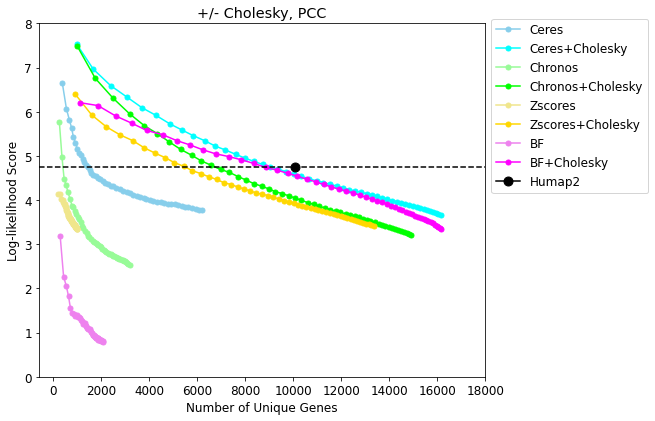

In [17]:
fig, ax= plt.subplots(figsize=(8,6.5))

plt.plot(CleanReactome_LLS_50k_C_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_PCC['LLS'],marker='o',markersize=5,  color='skyblue',label='Ceres')
plt.plot(CleanReactome_LLS_50k_C_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_Chol_PCC['LLS'],marker='o',markersize=5,color='cyan', label='Ceres+Cholesky')

plt.plot(CleanReactome_LLS_50k_CH_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_PCC['LLS'],marker='o',markersize=5,color='palegreen', label='Chronos')
plt.plot(CleanReactome_LLS_50k_CH_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_Chol_PCC['LLS'],marker='o',markersize=5, color='lime',label='Chronos+Cholesky')

plt.plot(CleanReactome_LLS_50k_Z_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_PCC['LLS'],marker='o',markersize=5,color='khaki', label='Zscores')
plt.plot(CleanReactome_LLS_50k_Z_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_Chol_PCC['LLS'],marker='o',markersize=5,color='gold',  label='Zscores+Cholesky')

plt.plot(CleanReactome_LLS_50k_BF_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_PCC['LLS'],marker='o',color='violet',markersize=5, label='BF')
plt.plot(CleanReactome_LLS_50k_BF_Chol_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_Chol_PCC['LLS'],marker='o',markersize=5, color='magenta',label='BF+Cholesky')


plt.plot(humap_cleanreactome_lls['numUniqGenes'],humap_cleanreactome_lls['LLS'],marker='o',color='black',markersize=9,label='Humap2')
plt.axhline(y=4.745677, linestyle='dashed', color='black')

plt.title('+/- Cholesky, PCC')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.03)) 
plt.yticks(np.arange(0,9,1))
plt.xticks(np.arange(0,20000,2000))

plt.ylabel('Log-likelihood Score')
plt.xlabel('Number of Unique Genes')
plt.show()


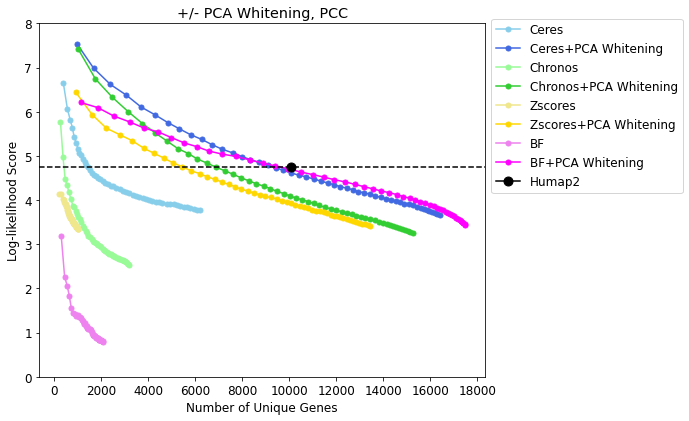

In [28]:
fig, ax= plt.subplots(figsize=(8,6.5))

plt.plot(CleanReactome_LLS_50k_C_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_PCC['LLS'],marker='o',markersize=5,  color='skyblue',label='Ceres')
plt.plot(CleanReactome_LLS_50k_C_White_PCC['numUniqGenes'],CleanReactome_LLS_50k_C_White_PCC['LLS'],marker='o',markersize=5,color='royalblue', label='Ceres+PCA Whitening')

plt.plot(CleanReactome_LLS_50k_CH_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_PCC['LLS'],marker='o',markersize=5,color='palegreen', label='Chronos')
plt.plot(CleanReactome_LLS_50k_CH_White_PCC['numUniqGenes'],CleanReactome_LLS_50k_CH_White_PCC['LLS'],marker='o',markersize=5, color='limegreen',label='Chronos+PCA Whitening')

plt.plot(CleanReactome_LLS_50k_Z_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_PCC['LLS'],marker='o',markersize=5,color='khaki', label='Zscores')
plt.plot(CleanReactome_LLS_50k_Z_White_PCC['numUniqGenes'],CleanReactome_LLS_50k_Z_White_PCC['LLS'],marker='o',markersize=5,color='gold',  label='Zscores+PCA Whitening')

plt.plot(CleanReactome_LLS_50k_BF_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_PCC['LLS'],marker='o',color='violet',markersize=5, label='BF')
plt.plot(CleanReactome_LLS_50k_BF_White_PCC['numUniqGenes'],CleanReactome_LLS_50k_BF_White_PCC['LLS'],marker='o',markersize=5, color='magenta',label='BF+PCA Whitening')


plt.plot(humap_cleanreactome_lls['numUniqGenes'],humap_cleanreactome_lls['LLS'],marker='o',color='black',markersize=9,label='Humap2')
plt.axhline(y=4.745677, linestyle='dashed', color='black')

plt.title('+/- PCA Whitening, PCC')
plt.legend(loc="upper left", bbox_to_anchor=(1, 1.03)) 
plt.yticks(np.arange(0,9,1))
plt.xticks(np.arange(0,20000,2000))

plt.ylabel('Log-likelihood Score')
plt.xlabel('Number of Unique Genes')
plt.show()
